In [1]:
import numpy as np
import os
import sys
from matplotlib.ticker import FormatStrFormatter
from matplotlib import pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from jax import device_get
import jax
import jax.numpy as jnp
import torch
from torch import Tensor
sys.path.append(os.path.expanduser("~"))
from utils import compute_pk
from UNet_apply import applyCNN, applyCNN_TF
from TF_utils import *
import Pk_library as PKL

cuda
1


[rank: 0] Seed set to 7


cuda


## Test Pk calculation & Pk Ratios

original density nbody map average: mean=4.24e+10, std=1.71e+12
4.24e+10, 1.71e+12
check if average is 0 for delta_nbody: mean=-4.46e-07, std=4.04e+01
check if average is 0 for delta_hydro: mean=1.68e-07, std=2.95e+01
(256, 256, 256) float32
0.12566370614359174


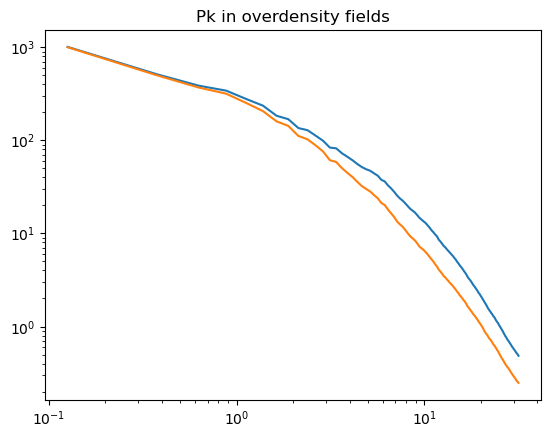

original density nbody map average: mean=4.23e+10, std=1.25e+12
0.12566370614359174


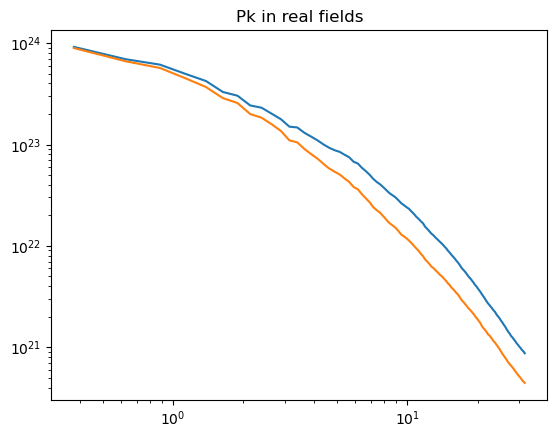

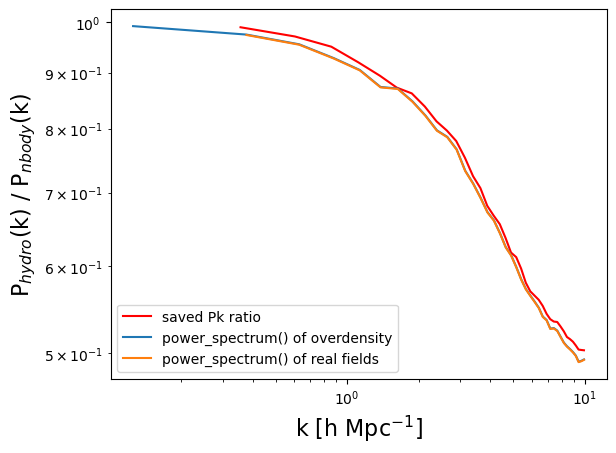

In [61]:
grid_dir = '/global/cfs/projectdirs/m4031/divijsharma/baryons-cfs/NBody/{}/{}/'.format('Astrid', 'LH')
grid_file = 'Grids_Mtot_Nbody_{}_{}_{}_z={}.npy'.format('Astrid', 'LH', 256, '0.0')
NBody_grid = np.load(grid_dir+grid_file, mmap_mode='c') #(1000, 256, 256, 256)
NBody_grid = NBody_grid[30]
print(f'original density nbody map average: mean={NBody_grid.mean():.2e}, std={NBody_grid.std():.2e}')

_, NBody_grid, NBody_mean = getGrid('Astrid', 'LH', 256, '0.0', 'nbody', 30)
_, hydro_grid, hydro_mean = getGrid('Astrid', 'LH', 256, '0.0', 'hydro', 30)
print(f'{((NBody_grid+1)*NBody_mean).mean():.2e}, {(NBody_grid*NBody_mean).std():.2e}')
print(f'check if average is 0 for delta_nbody: mean={NBody_grid.mean():.2e}, std={NBody_grid.std():.2e}')
print(f'check if average is 0 for delta_hydro: mean={hydro_grid.mean():.2e}, std={hydro_grid.std():.2e}')

print(NBody_grid.shape, NBody_grid.dtype)
'''
check for Pk -- Divij's overdensity
'''
box_size = 25
k_NBody, Pk_NBody = power_spectrum(NBody_grid, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 3))
k_hydro, Pk_hydro = power_spectrum(hydro_grid, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 3))
print(k_NBody[0])
#print(Pk_NBody[k_NBody==0], Pk_hydro[k_hydro==0]) #--> [4.3954946e-09] [2.3080293e-10] alomost ZERO!

plt.plot(k_NBody, Pk_NBody)
plt.plot(k_hydro, Pk_hydro)
plt.xscale('log')
plt.yscale('log')
plt.title('Pk in overdensity fields')
plt.show()

'''
check for Pk -- real valued field 
'''
NBody_og = (NBody_grid+1)*NBody_mean #--> confirm the correct way to transform back
x = np.mean(np.array(NBody_og), axis = 2) #(256, 256)
hydro_og = (hydro_grid+1)*hydro_mean
print(f'original density nbody map average: mean={hydro_og.mean():.2e}, std={hydro_og.std():.2e}')

k_NBody_, Pk_NBody_ = power_spectrum(NBody_og, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 3))
k_hydro_, Pk_hydro_ = power_spectrum(hydro_og, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 3))
print(k_NBody_[0])
#print(Pk_NBody[k_NBody==0], Pk_hydro[k_hydro==0]) #--> [inf] [inf] e23!

plt.plot(k_NBody_, Pk_NBody_)
plt.plot(k_hydro_, Pk_hydro_)
plt.xscale('log')
plt.yscale('log')
plt.title('Pk in real fields')
plt.show()

'''
check if Pkratios and GPresults are both overdensity ratio
'''
k, PkRatios = getPkRatios('Astrid', 'LH', 256, '0.0')
mask = k_hydro <= 10
mask_2 = k[0] <= 10
plt.figure()
plt.plot(k[30, mask_2], PkRatios[30, mask_2],label = 'saved Pk ratio', color='r')
plt.plot(k_hydro[mask], (Pk_hydro/Pk_NBody)[mask], label = 'power_spectrum() of overdensity')
plt.plot(k_hydro[mask], (Pk_hydro_/Pk_NBody_)[mask], label = 'power_spectrum() of real fields')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=16)
plt.ylabel(r'P$_{hydro}$(k) / P$_{nbody}$(k)', fontsize=16)  
plt.legend()
plt.show()

## Pylians.PKL
**Try Pk_library which is what CAMELS used https://camels.readthedocs.io/en/latest/examples/Pk.html**


Computing power spectrum of the field...
Time to complete loop = 0.70
Time taken = 0.76 seconds

Computing power spectrum of the field...
Time to complete loop = 0.70
Time taken = 0.77 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds
2D-z_stacked mean: -0.00013589859008789062, 2D-z_avg mean: -5.308538675308228e-07, 3D mean:-4.461908247321844e-07
(221,) (128,) (181,)

Computing power spectra of the fields...
Time FFTS = 0.14
Time loop = 0.57
Time taken = 0.72 seconds
float32 float64


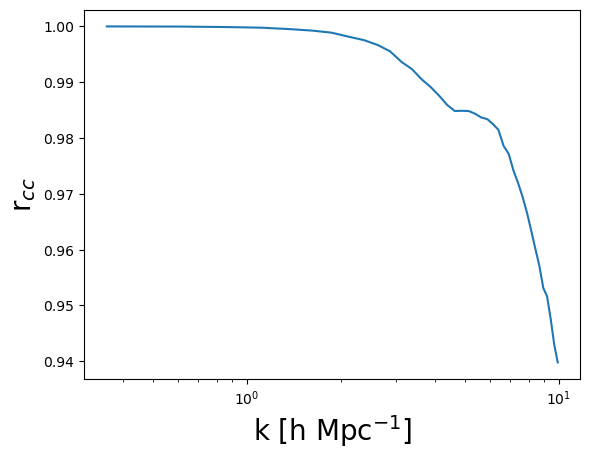

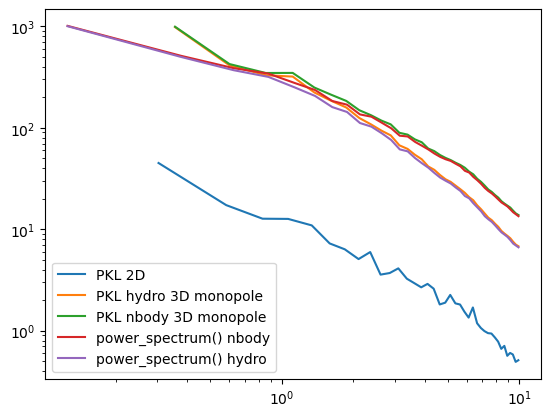

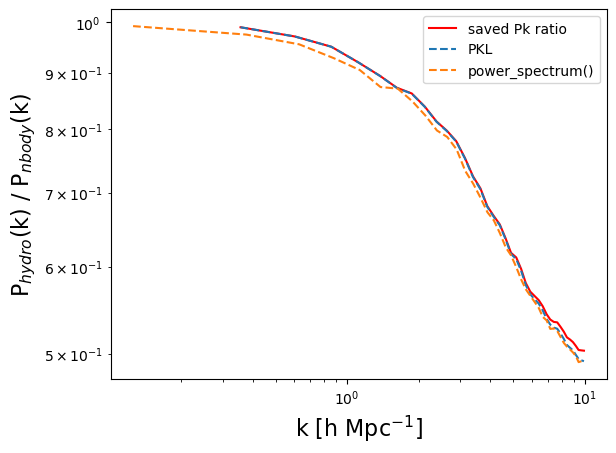

In [67]:
# parameters
grid    = 256     #the map will have grid^2 pixels
BoxSize = 25 #Mpc/h
MAS     = 'None'  #MAS used to create the image; 'NGP', 'CIC', 'TSC', 'PCS' o 'None'
threads = 1       #number of openmp threads
axis = 0
verbose = True

Pk3D_hydro = PKL.Pk(hydro_grid, BoxSize, axis, MAS, threads, verbose)
Pk3D_Nbody = PKL.Pk(NBody_grid, BoxSize, axis, MAS, threads, verbose)

# Pk is a python class containing the 1D, 2D and 3D power spectra, that can be retrieved as

# 3D P(k)
k1D      = Pk3D_hydro.k3D
Pk1D     = Pk3D_hydro.Pk[:,0]
k1D_nbody      = Pk3D_Nbody.k3D
Pk1D_nbody     = Pk3D_Nbody.Pk[:,0]

k1D_1D      = Pk3D_hydro.k1D
Pk1D_1D     = Pk3D_hydro.Pk1D


# 2D P(k)
Pkplane = PKL.Pk_plane(np.mean(np.array(NBody_grid), axis = 2), BoxSize, MAS, threads)
print(f'2D-z_stacked mean: {np.mean(np.sum(np.array(NBody_grid), axis = 2))}, 2D-z_avg mean: {np.mean(np.mean(np.array(NBody_grid), axis = 2))}, 3D mean:{np.mean(NBody_grid)}')
k2D      = Pkplane.k      #k in h/Mpc
Pk2D     = Pkplane.Pk    #Pk in (Mpc/h)^2
#Nmodes2D = Pk2D.Nmodes #Number of modes in the different k bins
print(Pk3D_hydro.Nmodes3D.shape, Pk3D_hydro.Nmodes1D.shape, Pkplane.Nmodes.shape)
scale = Pk1D[0]/Pk2D[0]

#Cross-correlation
Pkcc = PKL.XPk([hydro_grid,NBody_grid], BoxSize, axis, MAS=[MAS,MAS], threads=1)
kcc      = Pkcc.k3D
Pk0_X  = Pkcc.XPk[:,0,0] #monopole of 1-2 cross P(k)
Pk0_X /= np.sqrt(Pk3D_hydro.Pk[:,0]*Pk3D_Nbody.Pk[:,0])
    
print(hydro_grid.dtype, Pk0_X.dtype)

plt.figure()
plt.plot(kcc[kcc <= 10], Pk0_X[kcc <= 10])
plt.xscale('log')
plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
plt.ylabel(r'r$_{cc}$', fontsize=20)
plt.show()

plt.plot(k2D[k2D <= 10], Pk2D[k2D <= 10], label = 'PKL 2D') # --> you cannot compare 2D Pk(\propto k^2) with 3D monopole Pk(\propto k^3)
#plt.plot(k2D[k2D <= 10], (scale*Pk2D)[k2D <= 10], label =  v
plt.plot(k1D[k1D <= 10], Pk1D[k1D <= 10], label = 'PKL hydro 3D monopole')
plt.plot(k1D_nbody[k1D <= 10], Pk1D_nbody[k1D <= 10], label = 'PKL nbody 3D monopole')
plt.plot(k_NBody[mask], Pk_NBody[mask], label = 'power_spectrum() nbody')
plt.plot(k_hydro[mask], Pk_hydro[mask], label = 'power_spectrum() hydro')
#plt.plot(k1D_1D[k1D_1D <= 10], Pk1D_1D[k1D_1D <= 10], '--', label = 'PKL 1D')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.plot(k[30, mask_2], PkRatios[30, mask_2],label = 'saved Pk ratio', color='r')
plt.plot(k1D[k1D <= 10], (Pk1D/Pk1D_nbody)[k1D <= 10], '--', label = 'PKL')
plt.plot(k_hydro[mask], (Pk_hydro/Pk_NBody)[mask],'--', label = 'power_spectrum()')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=16)
plt.ylabel(r'P$_{hydro}$(k) / P$_{nbody}$(k)', fontsize=16)  
plt.legend()
plt.show()

## Test CNN apply

In [3]:
import importlib
import UNet_apply
import TF_utils # Import the module you want to reload
# Make changes to 'my_module.py'

importlib.reload(UNet_apply) 
importlib.reload(TF_utils) 
from UNet_apply import applyCNN
from TF_utils import *

[rank: 0] Seed set to 7


cuda


CometLogger will be initialized in online mode
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


suite: Astrid


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [35]:
Nbody_map = np.mean(np.array(NBody_grid), axis = 2) + 1
_, postTF_grid = applyCNN(torch.tensor(Nbody_map[np.newaxis,np.newaxis,:])) #torch.Size([1, 1, 1, 256, 256])
print(postTF_grid.mean(),postTF_grid.std())

suite: Astrid
tensor(1.0000, grad_fn=<MeanBackward0>) tensor(4.0773, grad_fn=<StdBackward0>)


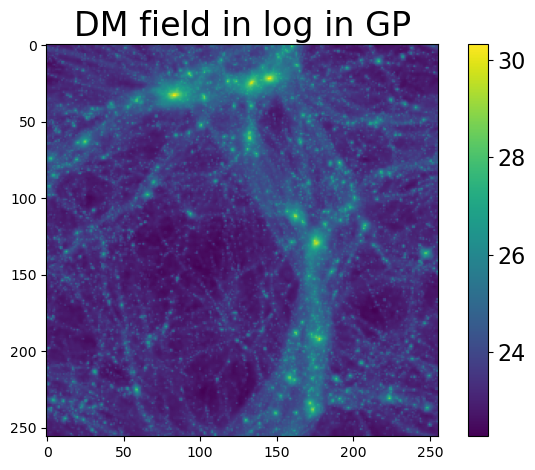

-4.46e-07
torch.Size([256, 256])


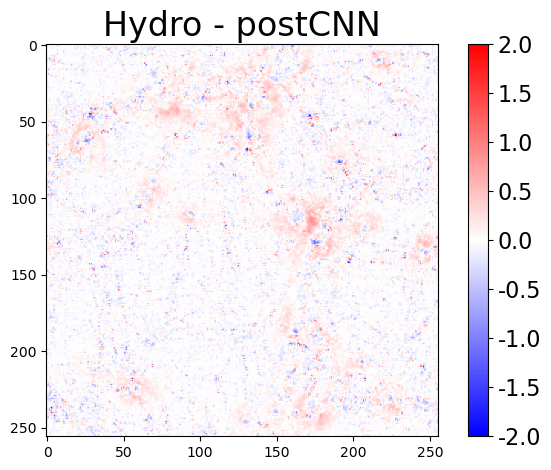

In [60]:
vmin = -2.0
vmax = 2.0

plt.figure()
plt.imshow(np.log(x))#, vmin=-2, vmax=5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title(f'DM field in log in GP', fontsize=24)
plt.tight_layout()
plt.show()
print(f'{NBody_grid.mean():.2e}')

# Ensure postTF_grid has the same shape as hydro_grid
if postTF_grid.shape != hydro_grid.shape[:2]:
    raise ValueError(f"Shape mismatch: postTF_grid shape {postTF_grid.shape} does not match hydro_grid shape {hydro_grid.shape[:2]}")
print(postTF_grid.shape)
plt.figure()
diff = np.log(np.mean(hydro_grid + 1, axis=2)) - np.log(postTF_grid.detach().numpy())
colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
cmap = LinearSegmentedColormap.from_list('custom', colors)
im = plt.imshow(diff, cmap=cmap, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=16)
plt.title('Hydro - postCNN', fontsize=24)
plt.tight_layout()
plt.show()

## Field Level plots for CNN and GP

In [2]:
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


def plotFieldLevelImages(sim, s, res, z, simulation_index = 30, model='GP'):
    if z == '0.47':
        z2 = '0.5'
    elif z == '0.95':
        z2 = '1.0'
    elif z == '1.48':
        z2 = '1.5'
    else:
        z2 = z

    CC_k, CC = getCrossCorrelations(sim, s, res, z2)
    mask = CC_k <= 10
    filtered_CC_k = CC_k[mask]
    filtered_CC = CC[:, mask]
    
    k, PkRatios = getPkRatios(sim, s, res, z)
    mask_2 = k[0] <= 10
    filtered_k = k[:, mask_2]
    filtered_PkRatios = PkRatios[:, mask_2]
    
    tolerance = 0.1
    close_to_1_mask = np.all(np.abs(filtered_CC - 1) < tolerance, axis=1)
    different_from_1_mask = np.any(np.abs(filtered_PkRatios - 1) > tolerance, axis=1)
    result_indices = np.where(close_to_1_mask & different_from_1_mask)[0]
    
    post_fit_ratios = getGP_post_fit(sim, s, res, z, smoothed=False)
    simulation_index = 30
    if sim == 'Astrid' and s == 'LH' and res == 256 and z == '0.0':
        distances = np.linalg.norm(post_fit_ratios - filtered_PkRatios[simulation_index], axis=1)
        post_fit_index = np.argmin(distances)
    else:
        post_fit_index = simulation_index
    print(simulation_index)
    print(post_fit_index)
    #print(post_fit_ratios[post_fit_index].shape) #(39,)

    
    _, NBody_grid, NBody_mean = getGrid(sim, s, res, z2, 'nbody', simulation_index)
    _, hydro_grid, hydro_mean = getGrid(sim, s, res, z2, 'hydro', simulation_index)
    
    #Load Model
    if model == 'GP':
        postTF_grid = applyTF(NBody_grid, filtered_k[0], post_fit_ratios[post_fit_index], 256, 25.0) #3D overdensity
    elif model == 'CNN':
        Nbody_map = np.mean(np.array(NBody_grid), axis = 2) + 1
        residual_grid, postTF_grid_ = applyCNN(torch.tensor(Nbody_map[np.newaxis,np.newaxis,:])) #torch.Size([1, 1, 1, 256, 256])
        postTF_grid = postTF_grid_.detach().numpy() - 1
    elif model == 'CNN_TF':
        Nbody_map = np.mean(np.array(NBody_grid), axis = 2) + 1
        residual_grid = applyCNN_TF(torch.tensor(Nbody_map[np.newaxis,np.newaxis,:])) #torch.Size([1, 1, 1, 256, 256])
        postTF_grid = applyTF_2D(Nbody_map -1, filtered_k[0], post_fit_ratios[post_fit_index], 256, 25.0)  + residual_grid.detach().numpy() #2D overdensity
        
    #Pk calculations
    grid    = 256     #the map will have grid^2 pixels
    BoxSize = 25 #Mpc/h
    MAS     = 'None'  #MAS used to create the image; 'NGP', 'CIC', 'TSC', 'PCS' o 'None'
    threads = 1       #number of openmp threads
    axis = 0
    verbose = True
    if model == 'GP':
        Pk3D_hydro = PKL.Pk(hydro_grid, BoxSize, axis, MAS, threads, verbose)
        Pk3D_Nbody = PKL.Pk(NBody_grid, BoxSize, axis, MAS, threads, verbose)
        Pk3D_postTF = PKL.Pk(np.array(postTF_grid, dtype=np.float32), BoxSize, axis, MAS, threads, verbose)
        k_Hydro   = Pk3D_hydro.k3D
        Pk_Hydro   = Pk3D_hydro.Pk[:,0]
        k_NBody   = Pk3D_Nbody.k3D
        Pk_NBody   = Pk3D_Nbody.Pk[:,0]
        k_postTF   = Pk3D_postTF.k3D
        Pk_postTF   = Pk3D_postTF.Pk[:,0]
         #post-fit Cross-correlation  -- confirmed its consistent with saved Rcc in getCrossCorrelations
        Pkcc = PKL.XPk([hydro_grid,np.array(postTF_grid, dtype=np.float32)],  BoxSize, axis, MAS=[MAS,MAS], threads=1) 
        kcc   = Pkcc.k3D
        Pk0_X  = Pkcc.XPk[:,0,0] #monopole of 1-2 cross P(k)
        Pk0_X /= np.sqrt(Pk_Hydro*Pk_postTF)
        #k_postTF, Pk_postTF = power_spectrum(postTF_grid, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 3))
        #k_residual, Pk_residual = power_spectrum(hydro_grid - postTF_grid, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 3))
        #k_NBody, Pk_NBody = power_spectrum(NBody_grid, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 3))
        #k_Hydro, Pk_Hydro = power_spectrum(hydro_grid, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 3))
    else:
        Pk2D_hydro = PKL.Pk_plane(np.mean(np.array(hydro_grid), axis = 2), BoxSize, MAS, threads, verbose)
        Pk2D_Nbody = PKL.Pk_plane(np.mean(np.array(NBody_grid), axis = 2), BoxSize,  MAS, threads, verbose)
        Pk2D_postTF = PKL.Pk_plane(np.array(postTF_grid, dtype=np.float32), BoxSize, MAS, threads, verbose) 
        k_Hydro   = Pk2D_hydro.k
        Pk_Hydro   = Pk2D_hydro.Pk
        k_NBody   = Pk2D_Nbody.k
        Pk_NBody   = Pk2D_Nbody.Pk
        k_postTF   = Pk2D_postTF.k
        Pk_postTF   = Pk2D_postTF.Pk
        #post-fit Cross-correlation -- more wiggly, slightly under saved Rcc from k~8
        Pkcc = PKL.XPk_plane(np.mean(np.array(hydro_grid), axis = 2),np.array(postTF_grid, dtype=np.float32),  BoxSize, MAS,MAS, threads=1) 
        kcc   = Pkcc.k
        Pk0_X = Pkcc.r
        #k_postTF, Pk_postTF = power_spectrum(postTF_grid, 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 2))
        #k_residual, Pk_residual = power_spectrum(residual_grid.detach().numpy(), 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 2))
        #k_NBody, Pk_NBody = power_spectrum(np.mean(np.array(NBody_grid), axis = 2), 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 2))
        #k_Hydro, Pk_Hydro = power_spectrum(np.mean(np.array(hydro_grid), axis = 2), 256, box_size, kmin=np.pi/box_size, dk=2*np.pi/box_size, boxsize=np.array([box_size] * 2))
    
    plt.figure()
    plt.plot(filtered_CC_k, filtered_CC[simulation_index], label = 'hydro-nbody')
    plt.plot(kcc[kcc <= 10], Pk0_X[kcc <= 10],label = f'hydro-{model}')
    plt.xscale('log')
    plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
    plt.ylabel(r'r$_{cc}$', fontsize=20)
    plt.title('z={}'.format(z2))
    plt.legend()
    plt.show()
    
    
    plt.figure()
    mask = k_Hydro <= 10
    # Apply the mask to filter k values and P(k) values
    plt.plot(k_Hydro[mask], Pk_Hydro[mask], label='Hydro')
    plt.plot(k_NBody[mask], Pk_NBody[mask], label='NBody')
    plt.plot(k_postTF[mask], Pk_postTF[mask], label=model)    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
    plt.ylabel(r'P(k)', fontsize=20)
    plt.legend(fontsize='xx-large')
    plt.tight_layout()     
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.tight_layout()
    # plt.savefig('GPemu-PaperPlots/{}_{}_{}_z={}_fl_Pk.pdf'.format(sim, s, res, z))
    plt.show()
    
    plt.figure()
    plt.imshow(np.log(np.mean(hydro_grid + 1, 2)), vmin=-2, vmax=5)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=16)
    plt.title('Hydro z={}'.format(z2), fontsize=24)
    plt.tight_layout()
    plt.show()
   
    
    plt.figure()
    diff = np.log(np.mean(hydro_grid + 1, 2)) - np.log(np.mean(NBody_grid + 1, 2))
    colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
    cmap = LinearSegmentedColormap.from_list('custom', colors)
    if z2 == '0.0':
        vmin = -2.0
        vmax = 2.0
    elif z2 == '0.5':
        vmin = -1.5
        vmax = 1.5
    elif z2 == '1.0':
        vmin = -1.0
        vmax = 1.0
    elif z2 == '1.5':
        vmin = -1.0
        vmax = 1.0
    im = plt.imshow(diff, cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
    cbar.ax.tick_params(labelsize=16)
    plt.title(f'Hydro - NBody: {diff.mean():.2e} +/- {diff.std():.2e}', fontsize=24)
    plt.tight_layout()
    plt.show()

    
    
    plt.figure()
    if model == 'GP':
        diff = np.log(np.mean(hydro_grid + 1, 2)) - np.log(np.mean(postTF_grid + 1, 2))
    else: 
        diff = np.log(np.mean(hydro_grid + 1, 2)) - np.log(postTF_grid + 1)
    colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
    cmap = LinearSegmentedColormap.from_list('custom', colors)
    im = plt.imshow(diff, cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, format=FormatStrFormatter('%.1f'))
    cbar.ax.tick_params(labelsize=16)
    plt.title(f'Hydro - {model}: {diff.mean():.2e} +/- {diff.std():.2e}', fontsize=24)
    plt.tight_layout()
    plt.show()

    
    plt.figure()
    if model == 'GP':
        plt.plot(filtered_k[0], post_fit_ratios[post_fit_index], label='GP TF')
    else:
        plt.plot(k_Hydro[mask], (Pk_postTF/Pk_NBody)[mask], label=model)
    plt.plot(filtered_k[0], filtered_PkRatios[simulation_index], label='Hydro/Nbody') #confirmed same as Pk_Hydro/Pk_NBody
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=20)
    plt.ylabel(r'P$_{hydro}$(k) / P$_{nbody}$(k)', fontsize=20)
    plt.legend(fontsize='xx-large')
    plt.tight_layout()
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.tight_layout()
    plt.show()
    
    error = 100*(Pk_Hydro-Pk_postTF)/Pk_Hydro
    plt.plot(k_NBody[mask], error[mask], color='r', label=model)
    plt.axhline(ls=':',c='k')
    plt.xscale('log')
    plt.xlabel(r'k [h Mpc$^{-1}$]', fontsize=16)
    plt.ylabel(r'Percent Error', fontsize=16)
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14) 
    plt.legend(fontsize='large')
    plt.tight_layout()
    plt.show()
    

30
151


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/global/homes/l/lindajin/.conda/envs/env1/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/global/homes/l/lindajin/UNet_apply.py:412: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be load

suite: Astrid

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.18 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


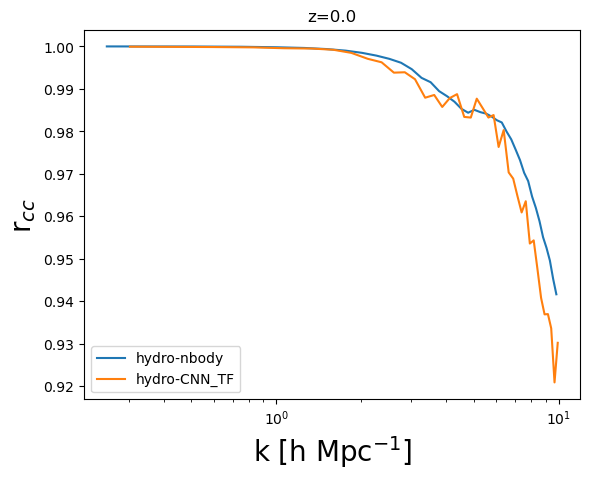

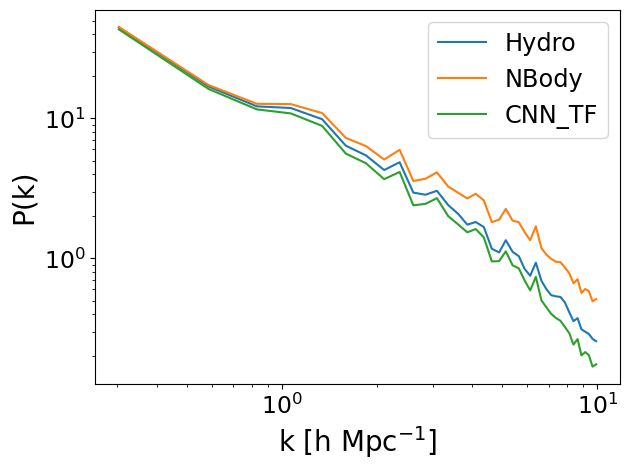

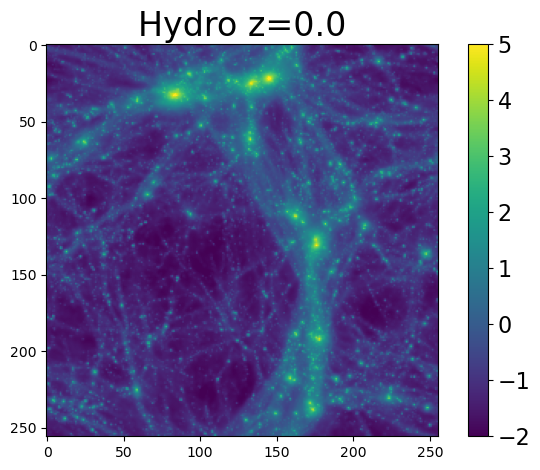

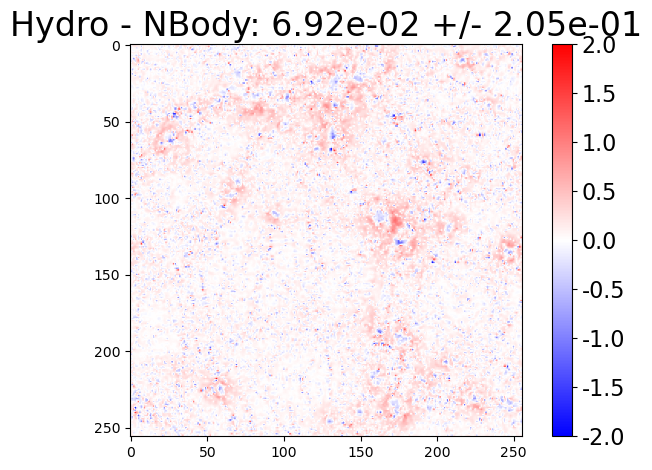

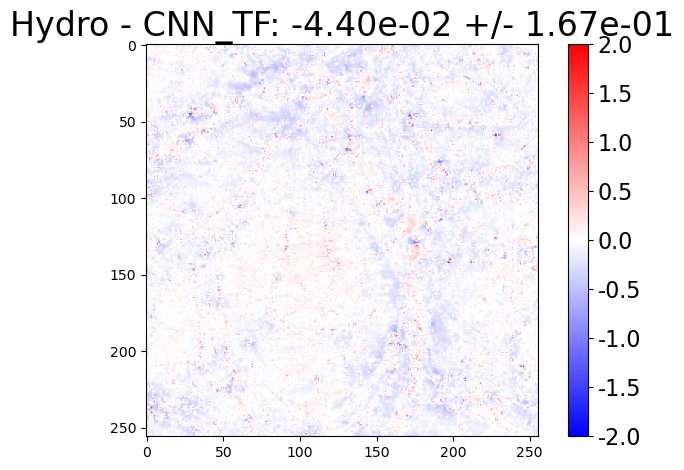

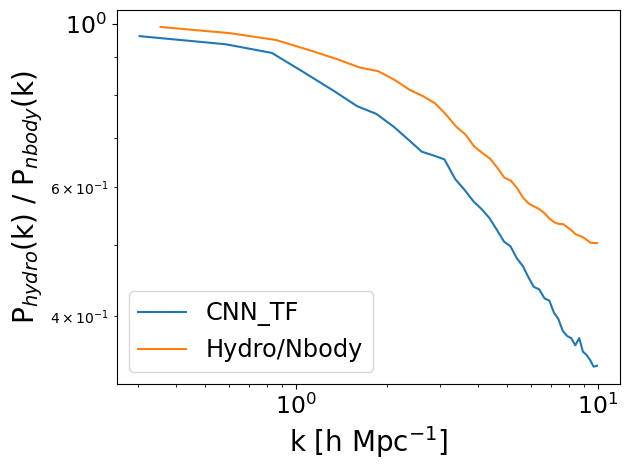

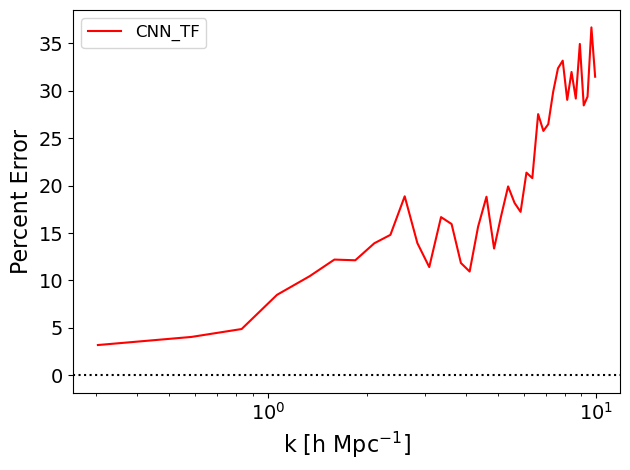

30
151
suite: Astrid

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


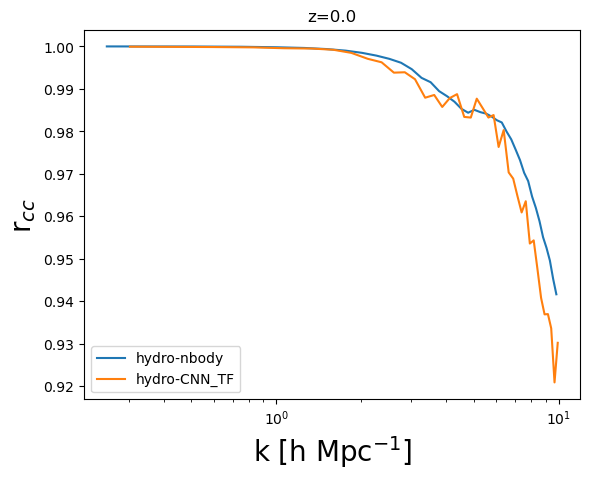

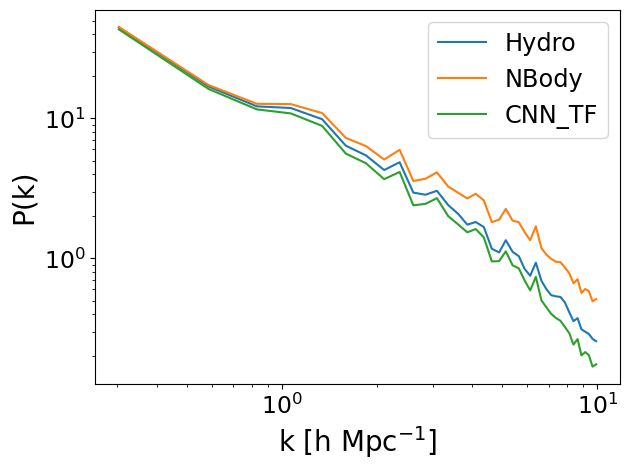

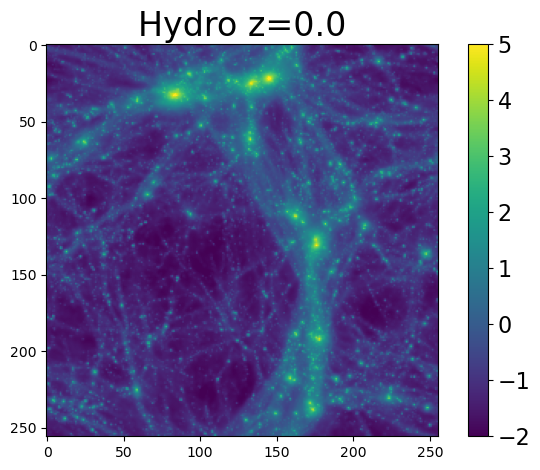

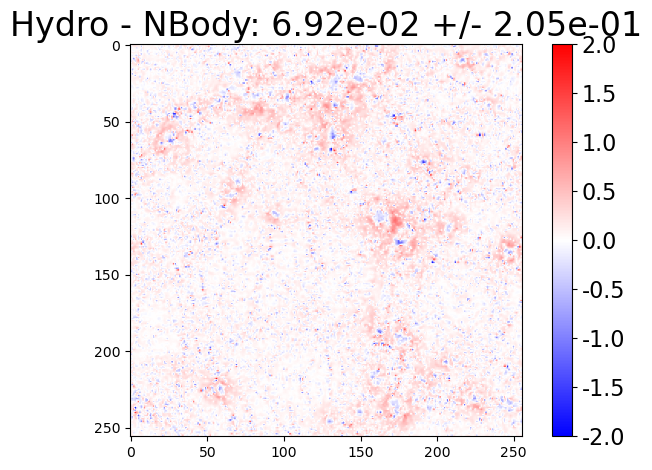

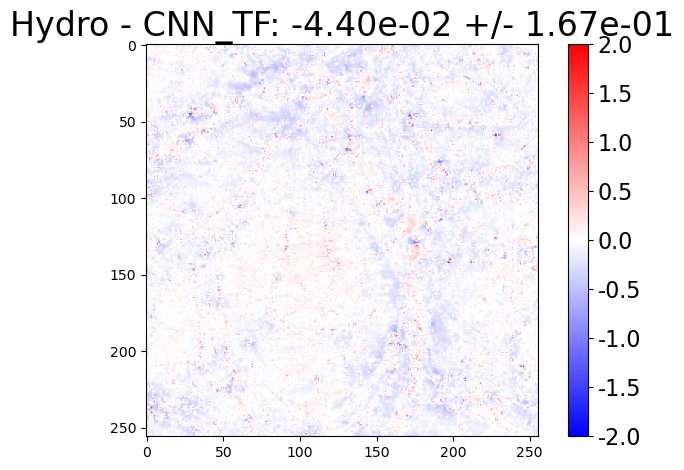

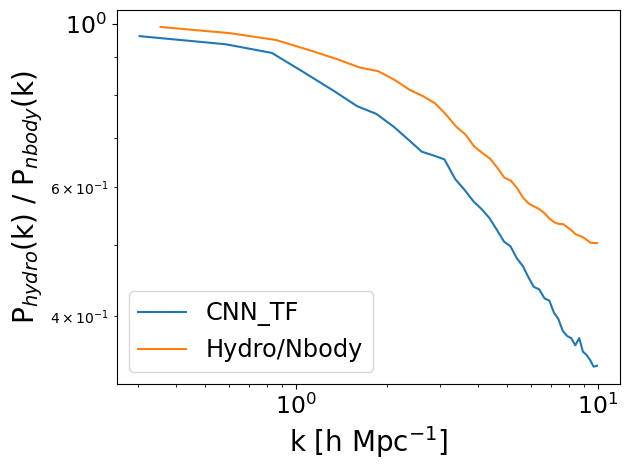

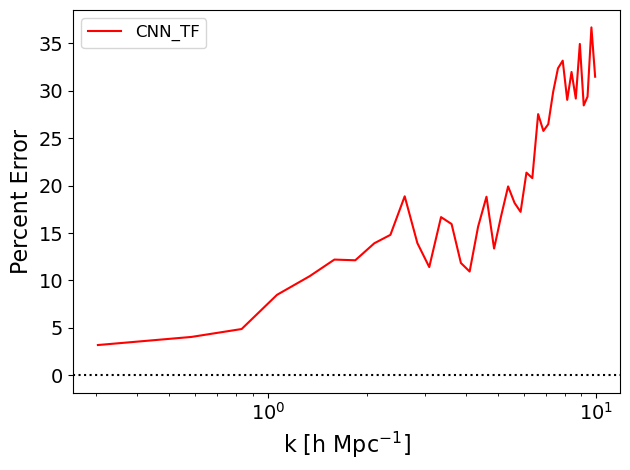

In [3]:
plotFieldLevelImages('Astrid', 'LH', 256, '0.0', 30, 'CNN_TF') #circular padding 
plotFieldLevelImages('Astrid', 'LH', 256, '0.0', 100, 'CNN_TF') #circular padding 

30
151


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/global/homes/l/lindajin/.conda/envs/env1/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/global/homes/l/lindajin/UNet_apply.py:412: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be load

suite: Astrid

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.01 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


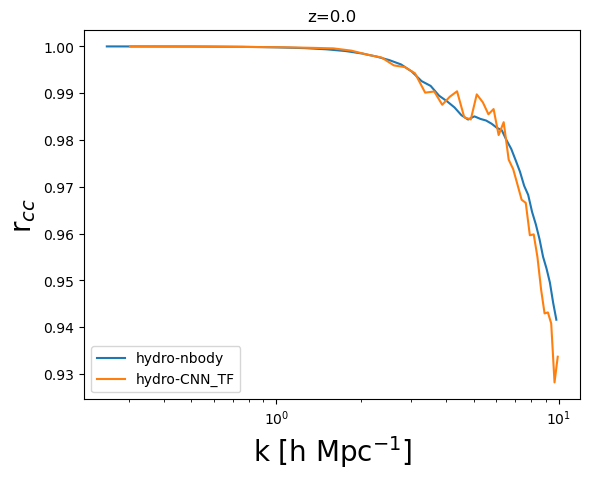

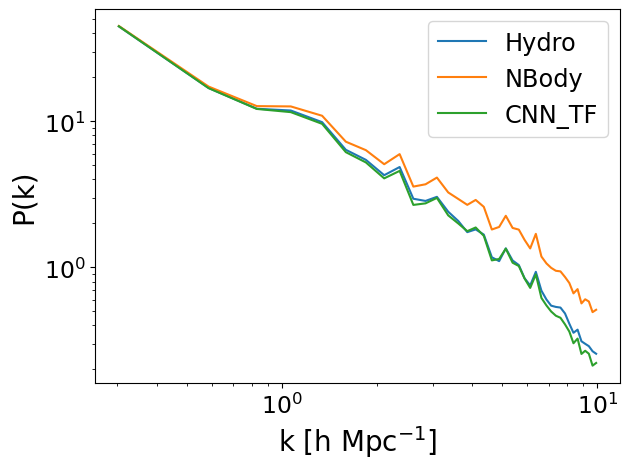

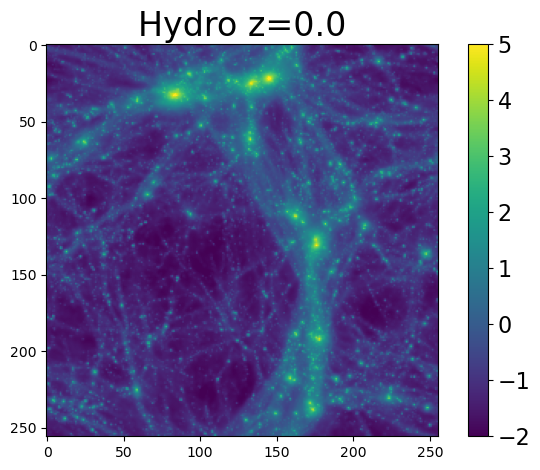

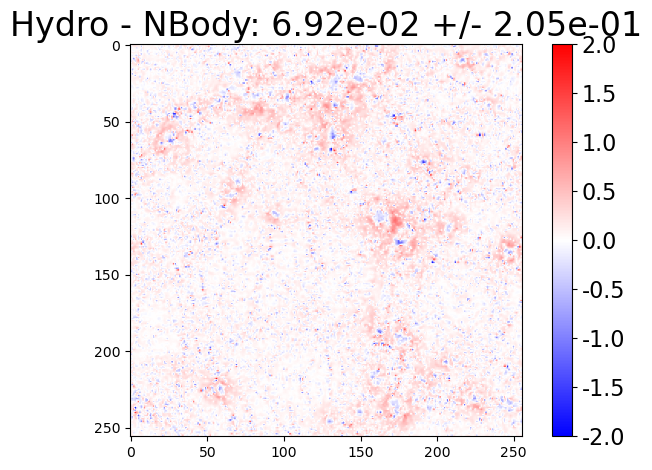

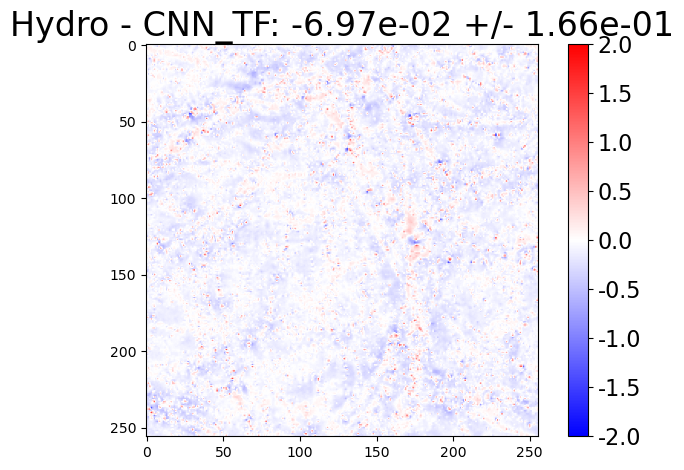

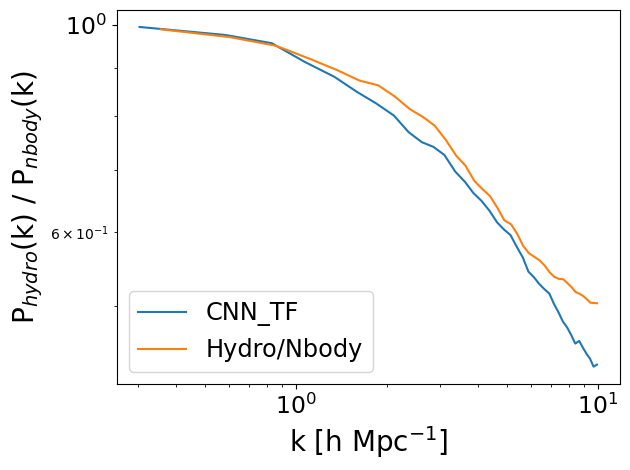

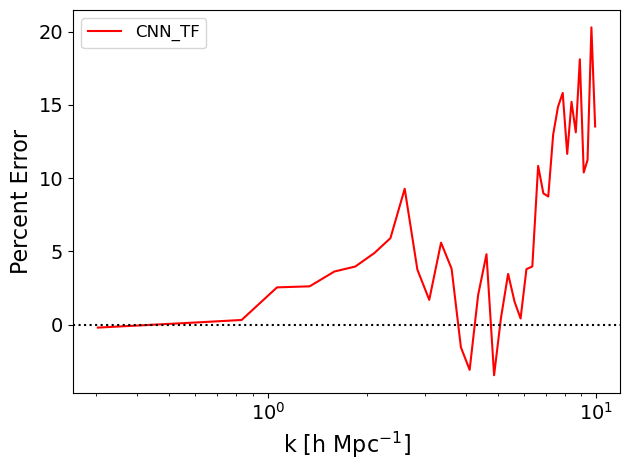

In [9]:
plotFieldLevelImages('Astrid', 'LH', 256, '0.0', 30, 'CNN_TF') #UNetVDM (wuth attention)

30
151
suite: Astrid

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.07 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


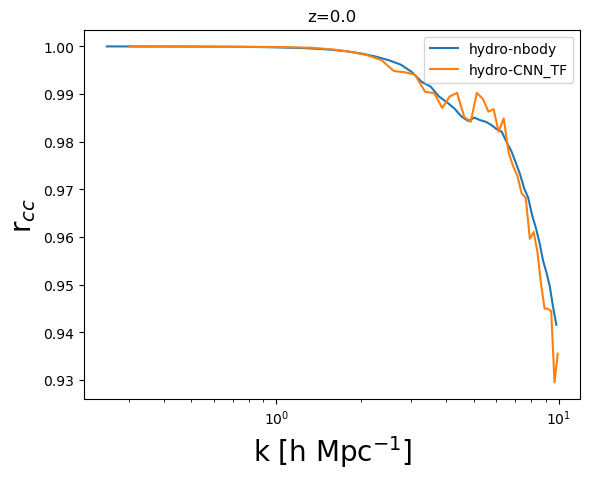

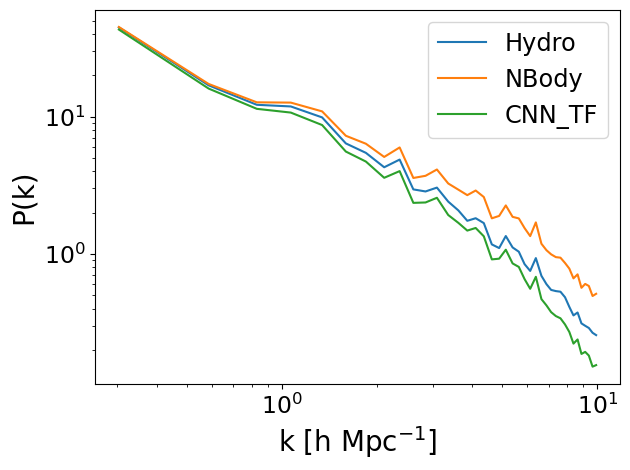

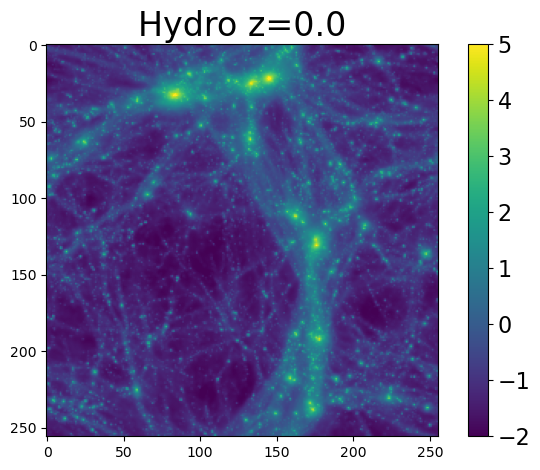

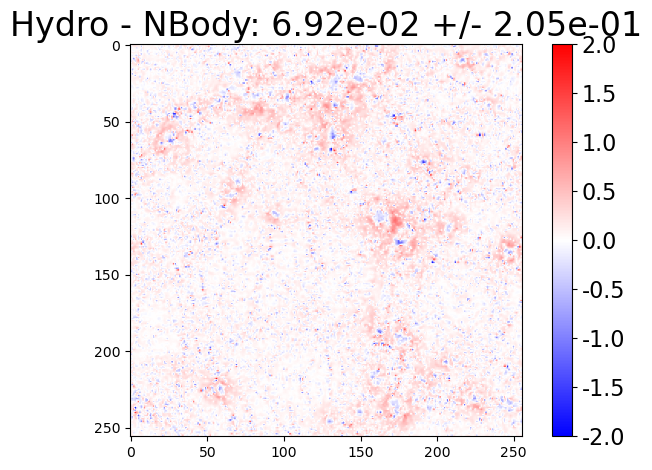

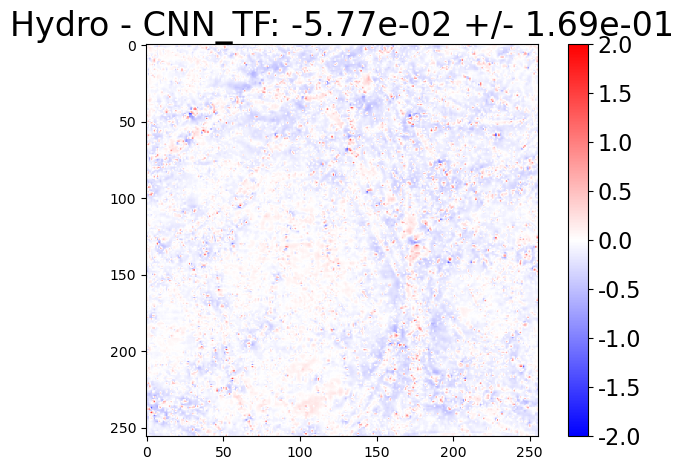

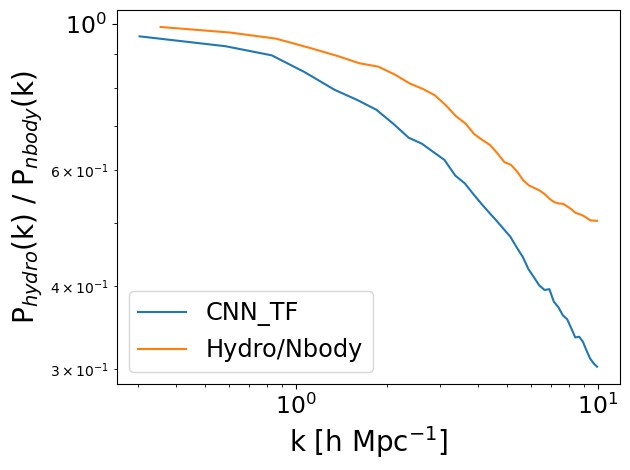

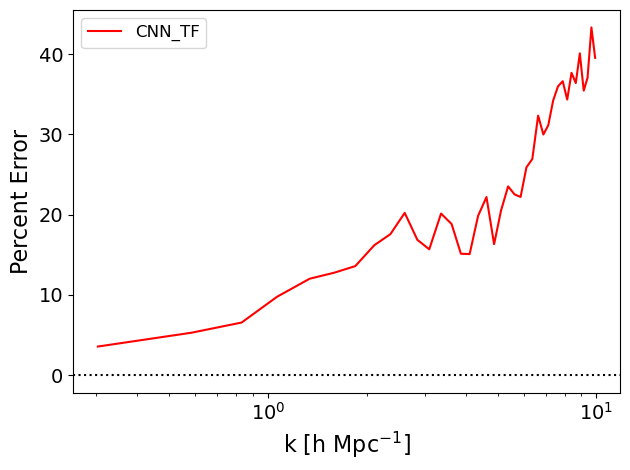

In [14]:
plotFieldLevelImages('Astrid', 'LH', 256, '0.0', 30, 'CNN_TF')

30
151

Computing power spectrum of the field...
Time to complete loop = 0.71
Time taken = 0.77 seconds

Computing power spectrum of the field...
Time to complete loop = 0.74
Time taken = 0.81 seconds

Computing power spectrum of the field...
Time to complete loop = 0.69
Time taken = 0.75 seconds

Computing power spectra of the fields...
Time FFTS = 0.14
Time loop = 0.58
Time taken = 0.72 seconds


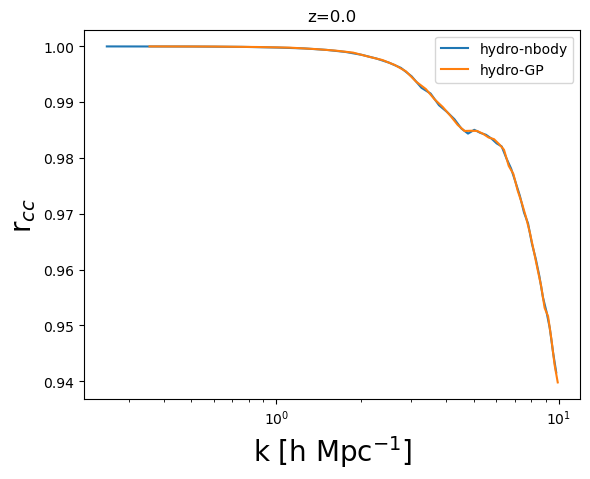

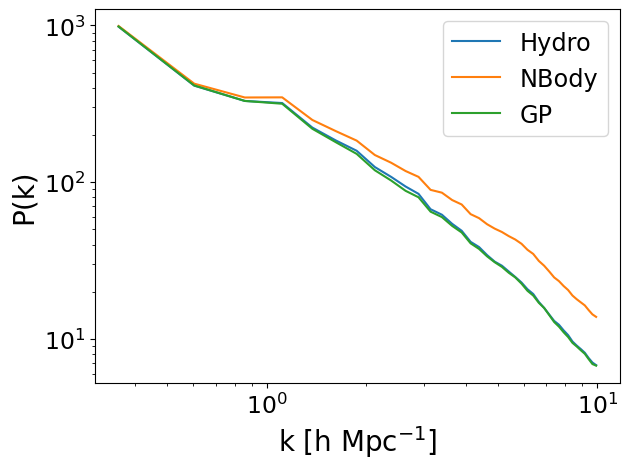

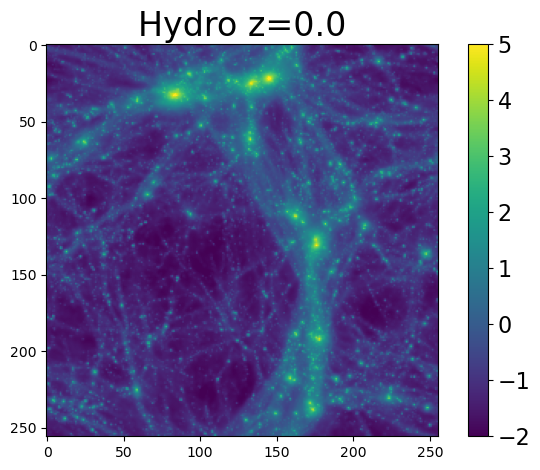

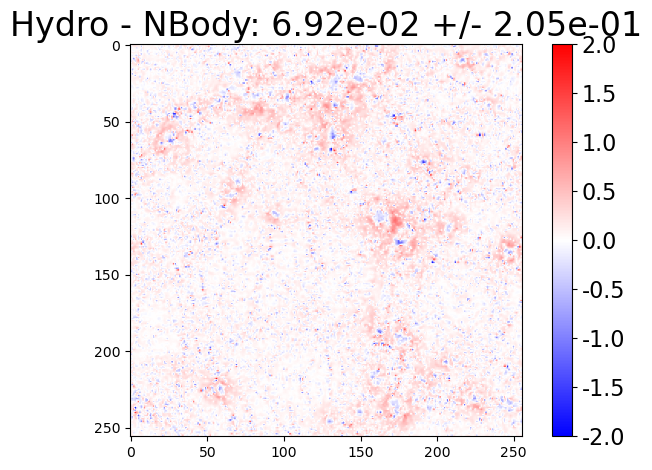

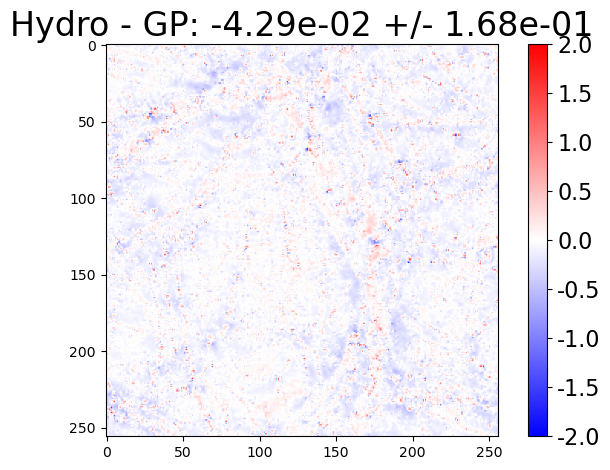

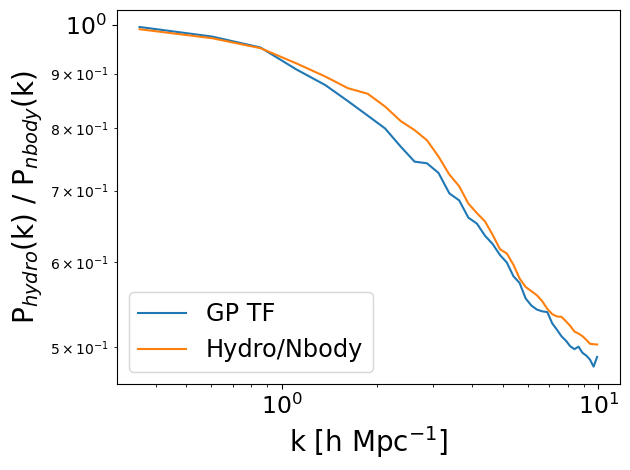

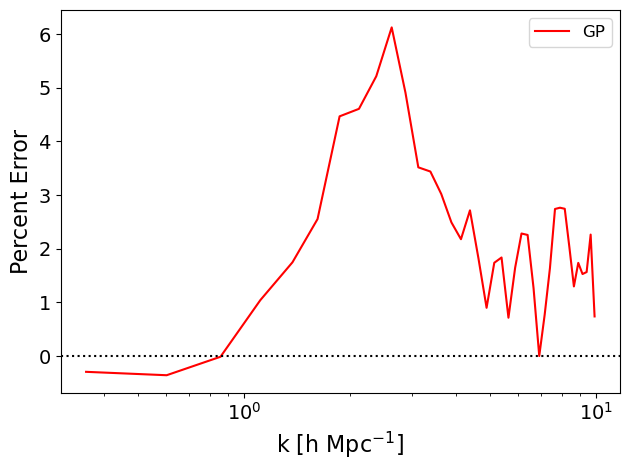

In [9]:
plotFieldLevelImages('Astrid', 'LH', 256, '0.0', 30, 'GP')

30
151
suite: Astrid


/global/homes/l/lindajin/UNet_apply.py:241: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict=torch.load(ckpt)["state_dict"]



Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds


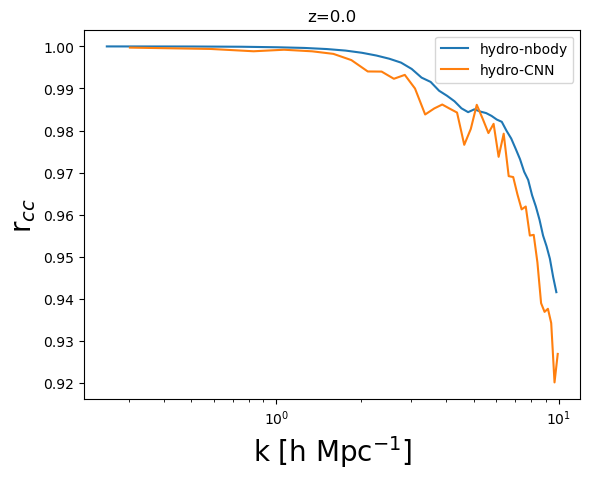

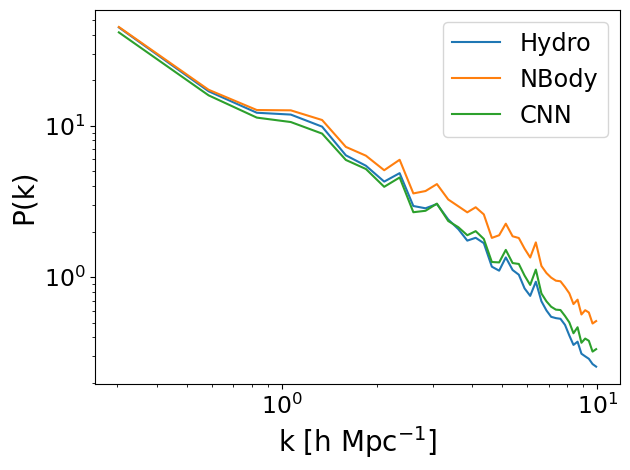

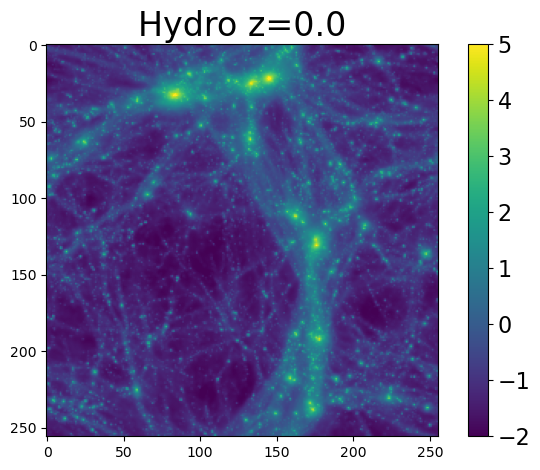

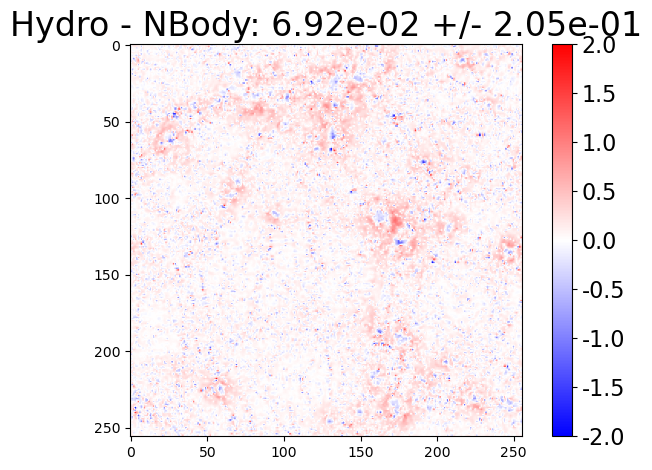

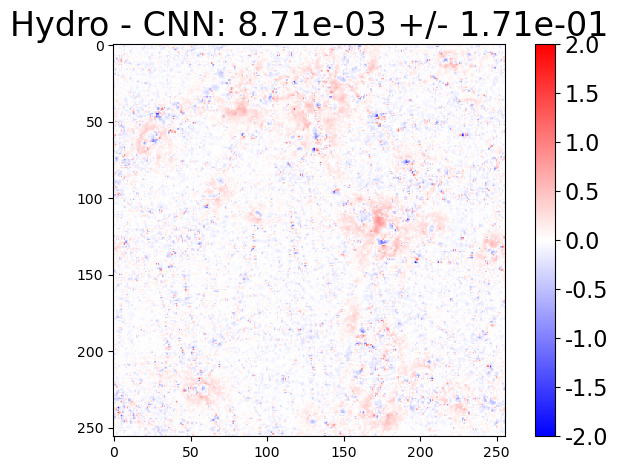

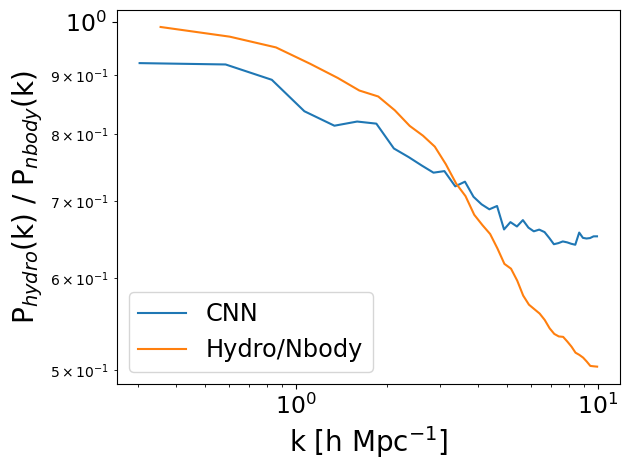

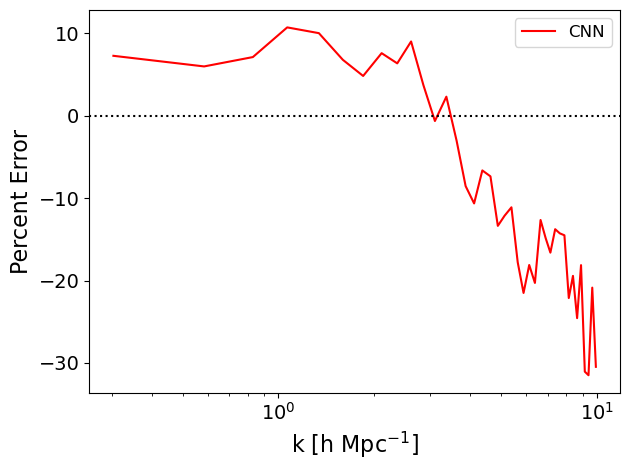

In [12]:
plotFieldLevelImages('Astrid', 'LH', 256, '0.0', 30, 'CNN')

## Test if 2D and 3D TF look the same

In [16]:
'''
Test if 2D and 3D TF look the same
'''
from itertools import cycle
def plotTF(sim, s, res, redshift, sim_inx = [30, 500, 900]):
    colormap = plt.cm.get_cmap('tab10')
    color_cycle = cycle(colormap.colors)
    
    #Real TF in 3D
    k, PkRatios = getPkRatios(sim, s, res, redshift)
    mask_2 = k[0] <= 10
    filtered_k = k[:, mask_2] #0.35598565 -- 9.92342616 (1000, 39)
    filtered_PkRatios = PkRatios[:, mask_2]
    post_fit_ratios = getGP_post_fit(sim, s, res, redshift, smoothed=False)
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    for i in sim_inx:
        if sim == 'Astrid' and s == 'LH' and res == 256 and redshift == '0.0':
            distances = np.linalg.norm(post_fit_ratios - filtered_PkRatios[i], axis=1)
            post_fit_index = np.argmin(distances)
        else:
            post_fit_index = i
    
    ### GP Apply in 3D ###
        _, NBody_grid, NBody_mean = getGrid(sim, s, res, redshift, 'nbody', i)
        _, hydro_grid, hydro_mean = getGrid(sim, s, res, redshift, 'hydro', i)
        postTF_grid = applyTF(NBody_grid, filtered_k[0], post_fit_ratios[post_fit_index], 256, 25.0)
        
    #Real TF in 2D
        NBody_og = (NBody_grid+1)*NBody_mean
        z = np.mean(np.array(NBody_og), axis = 2)
        _, Pk_nbody_2d_z = compute_pk(z[np.newaxis,np.newaxis,:])
        y = np.mean(np.array(NBody_og), axis = 1)
        _, Pk_nbody_2d_y = compute_pk(y[np.newaxis,np.newaxis,:])
        x = np.mean(np.array(NBody_og), axis = 0)
        _, Pk_nbody_2d_x = compute_pk(x[np.newaxis,np.newaxis,:])
        
        hydro_og = (hydro_grid+1)*hydro_mean
        x_ = np.mean(np.array(hydro_og), axis = 2)
        k, Pk_hydro_2d_z = compute_pk(x_[np.newaxis,np.newaxis,:])
        mask = k <= 10 #0.2513 -- 9.9253 (,40)
    
    ### GP Apply in 2D ###   -->  HOW WE ADD IN CNN
        postTF_grid_z = applyTF_2D(z, filtered_k[0], post_fit_ratios[post_fit_index], 256, 25.0)
        postTF_grid_y = applyTF_2D(y, filtered_k[0], post_fit_ratios[post_fit_index], 256, 25.0)
        postTF_grid_x = applyTF_2D(x, filtered_k[0], post_fit_ratios[post_fit_index], 256, 25.0)
        print(postTF_grid_x.shape)
        _, Pk_GP_hydro_2d_z = compute_pk(postTF_grid_z[np.newaxis,np.newaxis,:])
        _, Pk_GP_hydro_2d_y = compute_pk(postTF_grid_y[np.newaxis,np.newaxis,:])
        _, Pk_GP_hydro_2d_x = compute_pk(postTF_grid_x[np.newaxis,np.newaxis,:])
        '''
        remember we won't be able to apply GP on 3D 
        GP_hydro_og = (postTF_grid+1)*hydro_mean
        z = np.mean(np.array(GP_hydro_og), axis = 2)
        _, Pk_GP_hydro_2d_z = compute_pk(z[np.newaxis,np.newaxis,:])
        y = np.mean(np.array(GP_hydro_og), axis = 1)
        _, Pk_GP_hydro_2d_y = compute_pk(y[np.newaxis,np.newaxis,:])
        x = np.mean(np.array(GP_hydro_og), axis = 0)
        _, Pk_GP_hydro_2d_x = compute_pk(x[np.newaxis,np.newaxis,:])
        '''
        c = next(color_cycle)
        if i == sim_inx[0]:
            ax1.plot(filtered_k[0], filtered_PkRatios[i], color = c, label=f'3D_true_TF')
            ax1.plot(k[mask], (Pk_hydro_2d_z/Pk_nbody_2d_z)[mask], color = c, alpha=0.3, label=f'2D_true_TF_along_z')
            ax1.plot(filtered_k[0], post_fit_ratios[post_fit_index], color = c, linestyle='dashdot', label='3D_GP_fit')

            ax2.plot(k[mask], (Pk_GP_hydro_2d_z/Pk_nbody_2d_z)[mask], color = c, alpha=0.7,linestyle='--', label=f'2D_GP_along_z')
            ax2.plot(k[mask], (Pk_GP_hydro_2d_y/Pk_nbody_2d_y)[mask], color = c, alpha=0.7,linestyle=':', label=f'2D_GP_along_y')
            ax2.plot(k[mask], (Pk_GP_hydro_2d_x/Pk_nbody_2d_x)[mask], color = c, alpha=0.3,linestyle='-', label=f'2D_GP_along_x')
            ax2.plot(k[mask], (Pk_hydro_2d_z/Pk_nbody_2d_z)[mask], color = c, alpha=0.3, lw = 2.5,label=f'2D_true_TF_along_z')
            ax2.plot(filtered_k[0], post_fit_ratios[post_fit_index], color = c, linestyle='dashdot', label='3D_GP_fit')

        else:
            ax1.plot(filtered_k[0], filtered_PkRatios[i], color = c)
            ax1.plot(filtered_k[0], post_fit_ratios[post_fit_index], color = c, linestyle='dashdot')
            ax1.plot(k[mask], (Pk_hydro_2d_z/Pk_nbody_2d_z)[mask], color = c, alpha=0.3)
            
            ax2.plot(k[mask], (Pk_GP_hydro_2d_z/Pk_nbody_2d_z)[mask], color = c, alpha=0.7,linestyle='--')
            ax2.plot(k[mask], (Pk_GP_hydro_2d_y/Pk_nbody_2d_y)[mask], color = c, alpha=0.7,linestyle=':')
            ax2.plot(k[mask], (Pk_GP_hydro_2d_x/Pk_nbody_2d_x)[mask], color = c, alpha=0.3,linestyle='-')
            ax2.plot(k[mask], (Pk_hydro_2d_z/Pk_nbody_2d_z)[mask], color = c, alpha=0.3, lw = 2.5)
            ax2.plot(filtered_k[0], post_fit_ratios[post_fit_index], color = c, linestyle='dashdot')
        ax1.set_xscale('log')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
    ax1.set_xlabel(r'k [h Mpc$^{-1}$]', fontsize=16)
    ax1.set_ylabel(r'P$_{hydro}$(k) / P$_{nbody}$(k)', fontsize=16)  
    ax1.legend(fontsize='large')
    fig1.show()
    fig1.savefig('Pkratios_3D_2D.png')
    ax2.set_xlabel(r'k [h Mpc$^{-1}$]', fontsize=16)
    ax2.set_ylabel(r'P$_{GP}$(k) / P$_{nbody}$(k)', fontsize=16)
    ax2.legend(fontsize='large')
    fig2.show()
    fig2.savefig('Pkratios_GPfit_3D_2D.png')

/tmp/ipykernel_329658/983482172.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab10')


(256, 256)
(256, 256)
(256, 256)


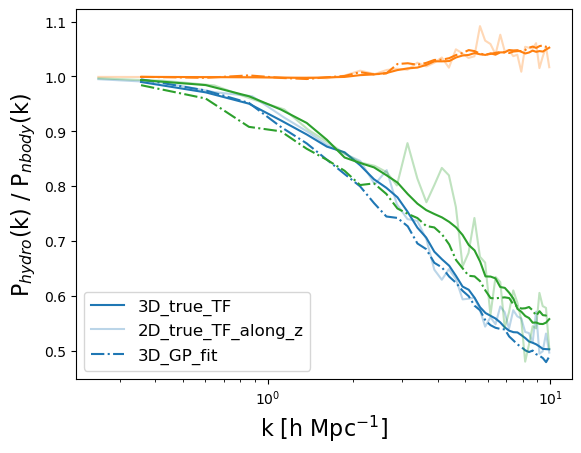

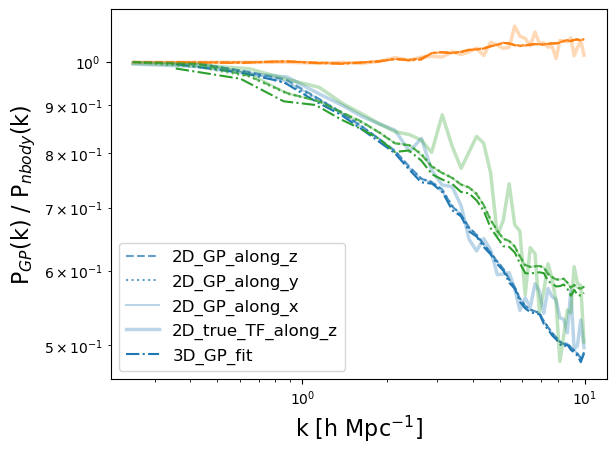

In [19]:
plotTF('Astrid', 'LH', 256, '0.0')